In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

# Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Lowering mutation rate

In [6]:
n_NS = len(genome)
n_p = 4600
n_r = 15
ep_wt = -5
er_wt = -15

mutrate = np.arange(0.03, 0.3, 0.01)
signal_rnap = []
signal_rep = []

for mr in mutrate:
    rnap = []
    rep = []
    for i in range(10):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                mutrate=float(mr))

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)
        nbins = 2

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    signal_rnap.append(np.mean(rnap))
    signal_rep.append(np.mean(rep))

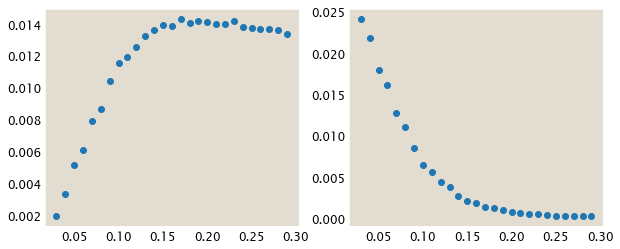

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes
ax1.scatter(mutrate, signal_rnap)
ax2.scatter(mutrate, signal_rep)
plt.show()

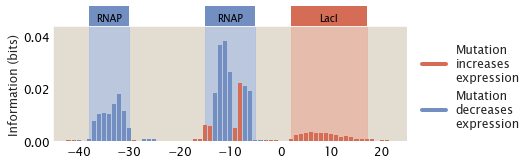

In [7]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.15)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=8,
                               outfile='../../figs/mutationrate15.png',
                               legend_xcoord=1.35)

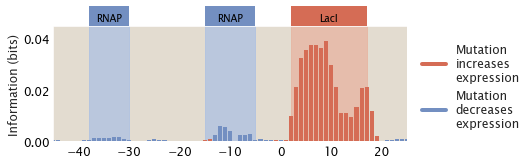

In [13]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.03)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=8,
                               outfile='../../figs/mutationrate03.png',
                               legend_xcoord=1.35)

### Double repression

In [6]:
rep1_site = promoter[(115-70):(115-60)]
rep2_site = promoter[(115-50):(115-40)]
r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

In [7]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -7
n_p, n_r1, n_r2 = 4600, 15, 15

mutrate = np.arange(0.03, 0.3, 0.01)
signal_rnap = []
signal_rep = []

for mr in mutrate:
    rnap = []
    rep = []
    for i in range(10):
        df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6, mutrate=float(mr))

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)
        nbins = 2

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append((np.mean(footprint[(-70+115):(-60+116)]) + np.mean(footprint[(-50+115):(-40+116)]))/2)
    signal_rnap.append(np.mean(rnap))
    signal_rep.append(np.mean(rep))

### Extreme case: what if we just have point mutations

In [16]:
def get_point_mutants(wtseq):
    mutants = []
    nts = ['A', 'T', 'C', 'G']
    for i, wt_nt in enumerate(wtseq):
        for nt in nts:
            if nt != wt_nt:
                mut = wtseq[:i] + nt + wtseq[(i + 1):]
                mutants.append(mut)
    return mutants

In [17]:
def simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                  rnap_emat, O1_emat, n_p, n_r, n_NS,
                  ep_wt, er_wt):

    l_simrep = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        rep_mut = mut[rep_start:rep_end].upper()
        rv['pbound'] = tregs.simulate.simrep_pbound(
                            rnap_mut, rep_mut, rnap_emat, O1_emat,
                            n_p, n_r, n_NS,
                            ep_wt=ep_wt, er_wt=er_wt)
        l_simrep.append(rv)
    df_simrep = pd.DataFrame.from_records(l_simrep)

    return df_simrep


def simrep_point_mutants(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, O1_emat, 
           ep_wt, er_wt, n_NS, n_p, n_r, scaling_factor=100):
    
    mutants = get_point_mutants(wtseq)
    
    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)

    df_simrep = simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                          rnap_emat, O1_emat, n_p, n_r, n_NS, ep_wt, er_wt)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    df_simrep['ct_1'] = 0.1 + df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(int)
    df_simrep['ct'] = df_simrep['ct_0'] + df_simrep['ct_1']

    df_simrep['ct'] = df_simrep['ct'].astype(float)
    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

In [18]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = simrep_point_mutants(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                       ep_wt, er_wt, n_NS, n_p, n_r)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))

In [19]:
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

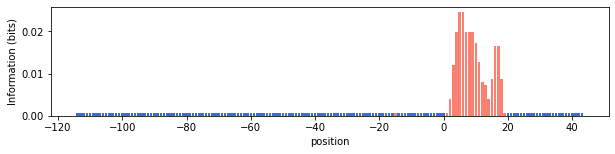

In [20]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()